In [1]:
# Checking GPU connection
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
     name=fn, length=len(uploaded[fn])))

Saving test500.csv to test500 (1).csv
Saving train5000.csv to train5000 (1).csv
User uploaded file "test500.csv" with length 650129 bytes
User uploaded file "train5000.csv" with length 2706640 bytes


# Files imported

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pre-processing
import nltk
# to remove stopwords
from nltk.corpus import stopwords
# to stem the words
from nltk.stem.snowball import SnowballStemmer
# for pretty printing
from pprint import pprint
# to remove punctuations from comments
import string

# Predicting
# to create bag-of-words
from sklearn.feature_extraction.text import CountVectorizer
# to allot tf-idf score to words
from sklearn.feature_extraction.text import TfidfTransformer
# to split into training and validation sets to avoid over-fitting
from sklearn.model_selection import cross_val_score
# naive bayes
from sklearn.naive_bayes import MultinomialNB
# svm
from sklearn import svm
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
# logistic regression
from sklearn.linear_model import LogisticRegression

# Neural network
# to pad comments
from keras.preprocessing.sequence import pad_sequences
# to create neural network model
from keras.models import Model
# for different kinds of layer
from keras.layers import Dense,Flatten,Input,Dropout,GlobalMaxPool1D,Conv1D
# to create word embeddings
from keras.layers.embeddings import Embedding
# to tokenize comments for input to neural network
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
# to reduce dimension of embedding and visualize
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [0]:
import io
data = pd.read_csv(io.StringIO(uploaded['train5000.csv'].decode('utf-8')))
test = pd.read_csv(io.StringIO(uploaded['test500.csv'].decode('utf-8')))

## Opening file in pandas DataFrame.

In [0]:
# Training data file.
#data=pd.read_csv(r'C:\Users\Dell\Desktop\Machine Learning\2018 Summer project\5000\train5000.csv')
data=data.iloc[0:5000,:]
data.drop('id',axis=1,inplace=True)
#data.head(10)

In [0]:
# adding a clean column
data['clean']=0
Col=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
data['clean'] = 1-data[Col].max(axis=1)

In [0]:
# Testing data file.
#test=pd.read_csv(r'C:\Users\Dell\Desktop\Machine Learning\2018 Summer project\5000\test500.csv')
test=test.iloc[0:300,:]
test.drop('id',axis=1,inplace=True)
#test.head(2)

Creating a new column containing number of words in each comment.

In [0]:
# Word length for sentence
def word_tokenize(sent):
    return len(nltk.word_tokenize(sent))
data['word_length']=data['comment_text'].apply(word_tokenize)

## Preprocessing

**Removing non-alphanumeric symbols like \n, punctuations and numbers.**

In [0]:
# Removes non-alphanumeric symbols like \n, punctuations and numbers.
import re
def strip_symbols(text):
   # return ' '.join(re.compile(r'\W+').split(text))
    return ' '.join(re.compile(r'[^a-zA-Z]').split(text)) 

# W+ matches any non-alphanumeric char
# re.compile() converts string to regular expression object
# .split(text) splits 

**Stop-words are words that occur frequently but carry negligible information. Example:'I','are','you',etc.**

**Below is the function to remove stop-words from the comments.**

In [0]:
# Function to remove stopwords from comments

def stop_word_removal(comment):
    stop_comment=[]
    # Removing the stopwords
    for word in comment.split(' '):
        if word not in stopwords.words('english'):
            stop_comment.append(word.lower())
    return ' '.join(stop_comment)

**The process of stemming of words is to reduce them to their root. Example:Stem word of 'listing' is 'list' and of 'commited' is 'commit'.**

**Below is the function to stem the comments.**

In [0]:
# Function to stem the comments
def stem(text):
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Applying preprocessing to training data.**

In [0]:
# Creating new columns which contains comments without non-alphanumeric char
data['comment-stop']=data['comment_text'].apply(strip_symbols)

# Normalizing=Converting to lowercase
data['comment-stop']=data['comment-stop'].apply(lambda x: x.lower())

# Removing short words
data['comment-stop']=data['comment-stop'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# Removing stop words
data['comment-stop']=data['comment-stop'].apply(lambda x:' '.join([w for w in x.split() if w not in stopwords.words('english')]))

# Stemming comments
data['comment-stem']=data['comment-stop'].apply(stem)


**Applying preprocessing to the testing data.**

In [0]:
# Creating new columns which contains comments without non-alphanumeric char
test['comment-stop']=test['comment_text'].apply(strip_symbols)

# Normalizing=Converting to lowercase
test['comment-stop']=test['comment-stop'].apply(lambda x: x.lower())

# Removing short words
test['comment-stop']=test['comment-stop'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# Removing stop words
test['comment-stop']=test['comment-stop'].apply(lambda x:' '.join([w for w in x.split() if w not in stopwords.words('english')]))

# Stemming comments
test['comment-stem']=test['comment-stop'].apply(stem)


## Predicting

**Comparing number of unique words in unclean, clean and stemmed comments.**

In [0]:
Col=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [23]:
# Unique words in unclean comments

x_stem=data['comment_text']
vector_stem=CountVectorizer()
transform_stem=vector_stem.fit_transform(x_stem)
print(transform_stem.shape) # rowsXwords 

#tfidf transform
tf_stem=TfidfTransformer()
tf_transform_stem=tf_stem.fit_transform(transform_stem)
print(tf_transform_stem.shape) # rowsXwords 

(5000, 24019)
(5000, 24019)


In [24]:
# Unique words in clean comments

x_stem=data['comment-stop']
vector_stem=CountVectorizer()
transform_stem=vector_stem.fit_transform(x_stem)
print(transform_stem.shape) # rowsXwords 

#tfidf transform
tf_stem=TfidfTransformer()
tf_transform_stem=tf_stem.fit_transform(transform_stem)
print(tf_transform_stem.shape) # rowsXwords 

(5000, 21206)
(5000, 21206)


In [25]:
# Unique words in stem comments

x_stem=data['comment-stem']

# Countvectorizer
vector_stem=CountVectorizer()
transform_stem=vector_stem.fit_transform(x_stem)
print(transform_stem.shape) # rowsXwords 

#Tfidf transform
tf_stem=TfidfTransformer()
tf_transform_stem=tf_stem.fit_transform(transform_stem)
print(tf_transform_stem.shape) # rowsXwords 


(5000, 15251)
(5000, 15251)


**We can see from above results that cleaning and stemming comments helps in reducing the number of unique words.**

**We can write unique stemmed words to a csv file.**

In [0]:
# words=transform_stem
# #words.columns=list_of_words

# df_word=pd.DataFrame(words.todense())
# df_word.columns=vector_stem.get_feature_names() # assigning column name based on the corresponding word

# df_word.to_csv('Words.csv',index=False)
# #df_word # Dataframe column contains word in sparse vector.

**Predicting on testing data.**

In [26]:
# example test comment
test_stem=[test['comment-stop'][0]]

test_vector_stem=CountVectorizer()
test_transform_stem=test_vector_stem.fit_transform(test_stem)

test_tf_stem=TfidfTransformer()
test_tf_transform_stem=test_tf_stem.fit_transform(test_transform_stem)
print(test_tf_transform_stem.shape) # rowsXwords 

(1, 35)


In [102]:
# the tokens in example sentence
print(test_vector_stem.get_feature_names())
# token id and number of occurence
print(test_transform_stem)

['ass', 'bein', 'bitch', 'boys', 'brother', 'diss', 'dont', 'ever', 'faces', 'fuckin', 'get', 'guys', 'hating', 'kiss', 'like', 'man', 'mofuckas', 'music', 'next', 'nothin', 'pethedic', 'pride', 'right', 'rule', 'sad', 'shit', 'sicken', 'slap', 'succesful', 'things', 'time', 'tupac', 'whats', 'white', 'wrong']
  (0, 30)	1
  (0, 18)	1
  (0, 22)	1
  (0, 29)	1
  (0, 3)	1
  (0, 9)	1
  (0, 4)	1
  (0, 31)	1
  (0, 14)	1
  (0, 1)	1
  (0, 34)	1
  (0, 19)	1
  (0, 25)	1
  (0, 5)	1
  (0, 6)	1
  (0, 15)	1
  (0, 17)	1
  (0, 21)	1
  (0, 26)	1
  (0, 11)	1
  (0, 0)	1
  (0, 13)	1
  (0, 10)	2
  (0, 8)	1
  (0, 33)	2
  (0, 20)	1
  (0, 27)	1
  (0, 16)	1
  (0, 24)	1
  (0, 12)	1
  (0, 32)	1
  (0, 7)	1
  (0, 28)	1
  (0, 23)	2
  (0, 2)	2


### Predicting on stemmed comments.

### Logistic Regression

In [27]:
# Logistic Regression
lr=LogisticRegression()

# print('Bag of words:\n')
# for target in Col:
#     score=cross_val_score(lr,transform_stem.toarray(),data[target],cv=2)
#     print(target,':',score.mean())
    
print('\nTfidf:\n')
for target in Col:
    score_tf=cross_val_score(lr,tf_transform_stem.toarray(),data[target],cv=2)
    print(target,':',score_tf.mean())


Tfidf:

toxic : 0.9147990263678443
severe_toxic : 0.9898000783680125
obscene : 0.9578
threat : 0.996
insult : 0.9509995921599348
identity_hate : 0.9902000784320126


**Predicting on an untrained example comment.**

In [28]:
# The example comment we are testing on.
# The comment no. is behind by two counts compared to the excel sheet.
print([test['comment-stem'][59]])

['fuck anti semit cunt']


In [29]:
for target in Col:
    lr.fit(transform_stem,data[target])
    print(target,':',lr.predict(vector_stem.transform([test['comment-stem'][59]])))

toxic : [1.]
severe_toxic : [0.]
obscene : [1.]
threat : [0.]
insult : [1.]
identity_hate : [0.]


### Naive Bayes

In [30]:
# Naive bayes on stemmed comments data
naive=MultinomialNB()

# print('Bag of words:\n')
# for target in Col:
#     score=cross_val_score(naive,transform_stem.toarray(),data[target],cv=2)
#     print(target,':',score.mean())
    
print('\nTfidf:\n')
for target in Col:
    score_tf=cross_val_score(naive,tf_transform_stem.toarray(),data[target],cv=2)
    print(target,':',score_tf.mean())


Tfidf:

toxic : 0.9028001444480231
severe_toxic : 0.9898000783680125
obscene : 0.9466
threat : 0.996
insult : 0.9456001512960241
identity_hate : 0.9902000784320126


**Predicting on an untrained example comment.**

In [31]:
for target in Col:
    naive.fit(transform_stem,data[target])
    print(target,':',naive.predict(vector_stem.transform([test['comment-stem'][99]])))

toxic : [1.]
severe_toxic : [0.]
obscene : [1.]
threat : [0.]
insult : [1.]
identity_hate : [0.]


### SVM

In [32]:
# Using best result for hyperparamter from gridsearchCV.

support=svm.SVC(kernel='linear',C=3,random_state=27)

Col=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    
print('\nTfidf:\n')
for target in Col:
    score_tf=cross_val_score(support,tf_transform_stem.toarray(),data[target],cv=2)
    print(target,':',score_tf.mean())



Tfidf:

toxic : 0.9373978299836528
severe_toxic : 0.9894000783040126
obscene : 0.971
threat : 0.9962
insult : 0.9593981535037046
identity_hate : 0.990199918431987


**Predicting on an untrained example comment.**

In [33]:
for target in Col:
    support.fit(transform_stem,data[target])
    print(target,':',support.predict(vector_stem.transform([test['comment-stem'][59]])))

toxic : [1.]
severe_toxic : [0.]
obscene : [1.]
threat : [0.]
insult : [1.]
identity_hate : [0.]


#### Just to check,predicted on comment 6 of data.

In [34]:
for target in Col:
    support.fit(transform_stem,data[target])
    print(target,':',support.predict(vector_stem.transform([data['comment-stem'][6]])))

toxic : [1.]
severe_toxic : [1.]
obscene : [1.]
threat : [0.]
insult : [1.]
identity_hate : [0.]


**Random Forest**

In [57]:
from sklearn.ensemble import RandomForestClassifier

rdf=RandomForestClassifier(n_estimators=30,random_state=27,max_depth=20)

Col=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

print('\nTfidf:\n')
for target in Col:
    score_tf=cross_val_score(rdf,tf_transform_stem.toarray(),data[target],cv=2)
    print(target,':',score_tf.mean())



Tfidf:

toxic : 0.8995999839359974
severe_toxic : 0.9898000783680125
obscene : 0.9463999999999999
threat : 0.996
insult : 0.9460001513600242
identity_hate : 0.9902000784320126


**Predicting on an untrained example comment.**

In [58]:
for target in Col:
    rdf.fit(transform_stem,data[target])
    print(target,':',rdf.predict(vector_stem.transform([test['comment-stem'][59]])))

toxic : [0.]
severe_toxic : [0.]
obscene : [0.]
threat : [0.]
insult : [0.]
identity_hate : [0.]


#### Just to check,predicted on comment 6 of data.

In [59]:
for target in Col:
    rdf.fit(transform_stem,data[target])
    print(target,':',rdf.predict(vector_stem.transform([data['comment-stem'][6]])))

toxic : [0.]
severe_toxic : [0.]
obscene : [0.]
threat : [0.]
insult : [0.]
identity_hate : [0.]


### KNN

In [35]:
# KNN
knn=KNeighborsClassifier(n_neighbors=5,algorithm='auto')

Col=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    
print('\nTfidf:\n')
for target in Col:
    score_tf=cross_val_score(knn,tf_transform_stem.toarray(),data[target],cv=2)
    print(target,':',score_tf.mean())


Tfidf:

toxic : 0.902200224352036
severe_toxic : 0.9899999983999997
obscene : 0.9488000000000001
threat : 0.996
insult : 0.9474000715840114
identity_hate : 0.9902000784320126


**Predicting on an untrained example comment.**

In [36]:
for target in Col:
    knn.fit(transform_stem,data[target])
    print(target,':',knn.predict(vector_stem.transform([test['comment-stem'][59]])))

toxic : [1.]
severe_toxic : [0.]
obscene : [1.]
threat : [0.]
insult : [0.]
identity_hate : [0.]


## Neural Network

In [0]:
# Creating object of Keras Tokeniser().
tokenizer=Tokenizer()
# Fit this object on stemming data.
tokenizer.fit_on_texts(x_stem)
# Saving the one-hot encoded format of words in a list.
sequence=tokenizer.texts_to_sequences(x_stem) # splits comments into a list of words(replaced by their index)

#tokenizer.fit_on_texts(list(x_unclean))
#sequence=tokenizer.texts_to_sequences(x_unclean)
#pprint(tokenizer.word_index)

In [62]:
!pip install wordcloud

    100% |████████████████████████████████| 368kB 6.1MB/s 


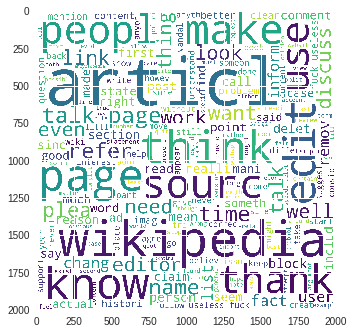

In [63]:
# Creating a wordcloud in which words are displayed in different sizes depending on their frequency 
# of occurence in the complete corpus.
from wordcloud import WordCloud
cloud=WordCloud(background_color='white',width=2000,height=2000).generate(' '.join(x_stem))
plt.imshow(cloud)

In [38]:
total_words=len(tokenizer.word_index)
print('Total unique words:',total_words) # total unique words
# **total unique words will go as input to embedding layer**

length_comment=[]
comment=x_stem

# Finding the maximum length comment.
for row in comment:
    length_comment.append(len(row.split(' ')))
max_length_comment=max(length_comment)
print('Max length comment:',max_length_comment) # max length of comment

Total unique words: 15251
Max length comment: 523


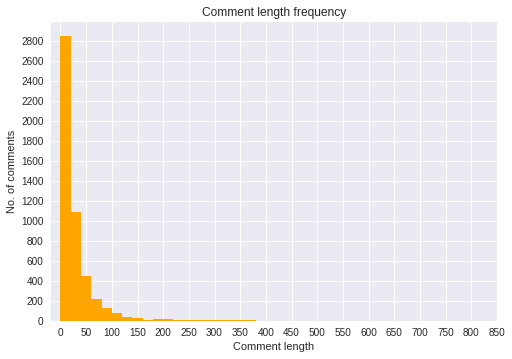

From above graph we can deduce that most comments have length about 0-50 words


In [68]:
# Saving comment length in a list.
totalNumWords = [len(comment) for comment in sequence]
# Plotting a histogram
plt.hist(totalNumWords,bins = range(0,400,20),color='orange')
plt.yticks(range(0,3000,200))
plt.xticks(range(0,900,50))
plt.title('Comment length frequency')
plt.ylabel('No. of comments')
plt.xlabel('Comment length')
plt.show()
print('From above graph we can deduce that most comments have length about 0-50 words')

In [0]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = data[list_classes].values

In [40]:
maxlen = max_length_comment
pad_doc = pad_sequences(sequence, maxlen=maxlen) # padding all comments to max comment length

inp = Input(shape=(maxlen, )) # Input layer
embed_size = 100
embed=Embedding(total_words+1, embed_size)(inp)
# input dimension=max_features, it is same as the no. of unique words in corpus
# output dimension/vector space dimension=embed_size
# output dimension is hyperparameter

x=Conv1D(filters=60,kernel_size=2,activation='relu')(embed) # 2nd layer;Convulation layer
#kernel-size=size of conv window
x = GlobalMaxPool1D()(x) # GlobalMaxPool1D Takes no argument
#x=GlobalAvgPool1D()(x)
x = Dropout(0.1)(x) # hyperparameter
x = Dense(50, activation="relu")(x) # 3rd layer
x = Dropout(0.1)(x) # hyperparameter
x = Dense(6, activation="softmax")(x) # output layer

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
batch_size = 32
epochs = 5
model.fit(pad_doc,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Train on 4500 samples, validate on 500 samples
Epoch 1/5
4500/4500 [==============================] - 3s 671us/step - loss: 0.2347 - acc: 0.9614 - val_loss: 0.2352 - val_acc: 0.9590
Epoch 2/5
4500/4500 [==============================] - 2s 400us/step - loss: 0.2271 - acc: 0.9624 - val_loss: 0.2320 - val_acc: 0.9593
Epoch 3/5
4500/4500 [==============================] - 2s 407us/step - loss: 0.2194 - acc: 0.9687 - val_loss: 0.2326 - val_acc: 0.9607
Epoch 4/5
4500/4500 [==============================] - 2s 398us/step - loss: 0.2135 - acc: 0.9706 - val_loss: 0.2334 - val_acc: 0.9600
Epoch 5/5
4500/4500 [==============================] - 2s 401us/step - loss: 0.2094 - acc: 0.9709 - val_loss: 0.2351 - val_acc: 0.9603


In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 523)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 523, 100)          1525200   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 522, 60)           12060     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [80]:
# donwloading glove file
!wget http://nlp.stanford.edu/data/glove.6B.zip


Redirecting output to ‘wget-log.1’.


In [86]:
# unzip glove file
!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [87]:
!ls
!pwd

glove.6B.100d (1).txt  glove.6B.50d.txt  test500 (1).csv    wget-log
glove.6B.100d.txt      glove.6B.zip	 test500.csv	    wget-log.1
glove.6B.200d.txt      glove.6B.zip.1	 train5000 (1).csv
glove.6B.300d.txt      sample_data	 train5000.csv
/content


In [0]:
embeddings_index = {}  # dictionary containing glove words
f = open('glove.6B.100d.txt',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0] # saves word
    coefs = np.asarray(values[1:], dtype='float32')  # saves dimension coefficiants of the words
    embeddings_index[word] = coefs # saving in dictionary with key as the word
f.close()

In [0]:
embedding_matrix = np.zeros((total_words+1, embed_size))  # create a matrix of zeros
for word, i in tokenizer.word_index.items(): # get tokenized words
    embedding_vector = embeddings_index.get(word) # get word from dictionary
    if embedding_vector is not None: # if the word was present
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [90]:
# example embedding
embeddings_index.get('the') # 100 dimensional

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [91]:
maxlen = max_length_comment
pad_doc = pad_sequences(sequence, maxlen=maxlen) # padding all comments to max comment length

inp = Input(shape=(maxlen, )) # Input layer
embed_size = 100
embed=Embedding(total_words+1, embed_size,weights=[embedding_matrix],trainable=False,input_length=maxlen)(inp)
# input dimension=max_features, it is same as the no. of unique words in corpus
# output dimension/vector space dimension=embed_size
# output dimension is hyperparameter

x=Conv1D(filters=60,kernel_size=2,activation='relu')(embed) # 2nd layer;Convulation layer
#kernel-size=size of conv window
x = GlobalMaxPool1D()(x) # GlobalMaxPool1D Takes no argument
#x=GlobalAvgPool1D()(x)
x = Dropout(0.1)(x) # hyperparameter
x = Dense(50, activation="relu")(x) # 3rd layer
x = Dropout(0.1)(x) # hyperparameter
x = Dense(6, activation="softmax")(x) # output layer

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
batch_size = 32
epochs = 5
model.fit(pad_doc,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Train on 4500 samples, validate on 500 samples
Epoch 1/5
4500/4500 [==============================] - 2s 380us/step - loss: 0.2370 - acc: 0.9592 - val_loss: 0.2339 - val_acc: 0.9590
Epoch 2/5
4500/4500 [==============================] - 1s 304us/step - loss: 0.2299 - acc: 0.9617 - val_loss: 0.2326 - val_acc: 0.9590
Epoch 3/5
4500/4500 [==============================] - 1s 306us/step - loss: 0.2275 - acc: 0.9624 - val_loss: 0.2321 - val_acc: 0.9593
Epoch 4/5
4500/4500 [==============================] - 1s 298us/step - loss: 0.2252 - acc: 0.9630 - val_loss: 0.2316 - val_acc: 0.9610
Epoch 5/5
4500/4500 [==============================] - 1s 302us/step - loss: 0.2246 - acc: 0.9634 - val_loss: 0.2316 - val_acc: 0.9610


In [92]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 523)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 523, 100)          1525200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 522, 60)           12060     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

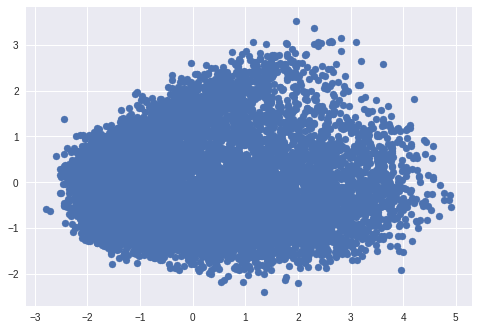

In [93]:
# visualisation using PCA
pca=PCA(n_components=2)
pca.fit(embedding_matrix)
X_pca=pca.transform(embedding_matrix)
plt.scatter(X_pca[:,0],X_pca[:,1])

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


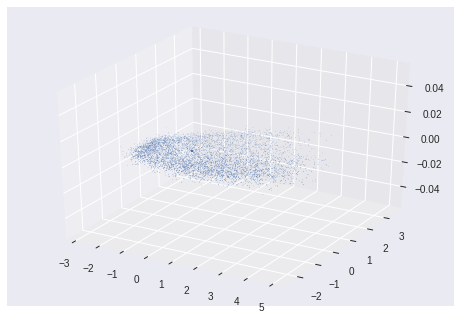

In [94]:
from mpl_toolkits.mplot3d import Axes3D

pca=PCA(n_components=3)
pca.fit(embedding_matrix)
X_pca=pca.transform(embedding_matrix)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(X_pca[:,0],X_pca[:,1],X_pca[:2])
plt.show()